# Dataset Overview

One ecommerce company has a project on predicting churned users in order to offer potential promotions.

An attached file is the dataset that is offered by the company (churn_predict.csv). You will be using this dataset to answer below questions:

# Questions

1. What are the patterns/behaviors of churned users? What are your suggestions to the company to reduce churned users?
2. Build the Machine Learning model for predicting churned users.


| Variable | Description |
|----------|-------------|
| CustomerID | Unique customer ID |
| Churn | Churn Flag |
| Tenure | Tenure of customer in organization |
| PreferredLoginDevice | Preferred login device of customer |
| CityTier | City tier |
| WarehouseToHome | Distance between warehouse to home of customer |
| PreferredPaymentMode | Preferred payment method of customer |
| Gender | Gender of customer |
| HourSpendOnApp | Number of hours spent on mobile application or website |
| NumberOfDeviceRegistered | Total number of devices registered by a particular customer |
| PreferedOrderCat | Preferred order category of customer in the last month |
| SatisfactionScore | Satisfactory score of customer on service |
| MaritalStatus | Marital status of customer |
| NumberOfAddress | Total number of addresses added by a particular customer |
| Complain | Any complaint has been raised in the last month |
| OrderAmountHikeFromLastYear | Percentage increase in order from last year |
| CouponUsed | Total number of coupons has been used in the last month |
| OrderCount | Total number of orders has been placed in the last month |
| DaySinceLastOrder | Days since last order by customer |
| CashbackAmount | Average cashback in the last month |

![reduce-churn-1160x653](reduce-churn-1160x653.jpg)


In [8]:
import pandas
import matplotlib.pyplot as pyplot
import seaborn

churn_df = pandas.read_excel('churn_prediction.xlsx', sheet_name = 'Sheet1')
churn_df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [9]:
# Configurations and Constants
pyplot.style.use('seaborn-v0_8')

color_churned = '#cf6a4e'
color_not_churned= '#93cc62'

# Data Processing

In [10]:
# Check possible duplications in columns that should have only unique values
churn_df['CustomerID'].duplicated().sum()

0

In [11]:
# Manually check unique values of categorical columns
categorical_columns = ['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'Complain']
for col in categorical_columns:
    print(f'- {col}\'s unique values: {churn_df[col].unique()}')

- PreferredLoginDevice's unique values: ['Mobile Phone' 'Phone' 'Computer']
- CityTier's unique values: [3 1 2]
- PreferredPaymentMode's unique values: ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
- Gender's unique values: ['Female' 'Male']
- PreferedOrderCat's unique values: ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
- SatisfactionScore's unique values: [2 3 5 4 1]
- MaritalStatus's unique values: ['Single' 'Divorced' 'Married']
- Complain's unique values: [1 0]


In [12]:
# Replace values that seems duplicated and review
churn_df['PreferredLoginDevice'] = churn_df['PreferredLoginDevice'].apply(lambda dev: 'Mobile Phone' if dev == 'Phone' else dev)

churn_df['PreferedOrderCat'] = churn_df['PreferedOrderCat'].apply(lambda cat: 'Mobile Phone' if cat == 'Mobile' else cat)

churn_df['PreferredPaymentMode'] = churn_df['PreferredPaymentMode'].apply(lambda mode: 'Cash on Delivery' if mode == 'COD' else mode)

churn_df['PreferredPaymentMode'] = churn_df['PreferredPaymentMode'].apply(lambda mode: 'Credit Card' if mode == 'CC' else mode)

for col in ['PreferredLoginDevice', 'PreferredPaymentMode', 'PreferedOrderCat']:
    print(f'- {col}\'s unique values: {churn_df[col].unique()}')


- PreferredLoginDevice's unique values: ['Mobile Phone' 'Computer']
- PreferredPaymentMode's unique values: ['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']
- PreferedOrderCat's unique values: ['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']


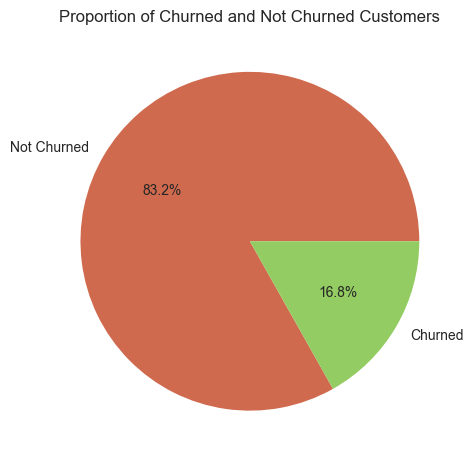

In [13]:
# Check data imbalance
churn_value_ratio_sr = churn_df['Churn'].value_counts()
churn_value_ratio_sr.plot(
    kind='pie',
    title='Proportion of Churned and Not Churned Customers',
    labels=['Not Churned', 'Churned'],
    autopct='%1.1f%%',
    ylabel='',
    colors=[color_churned, color_not_churned]
)
pyplot.show()

- 20-40%: normal ratio
- **_1-20%: quite imbalanced_**
- <1%: imbalanced

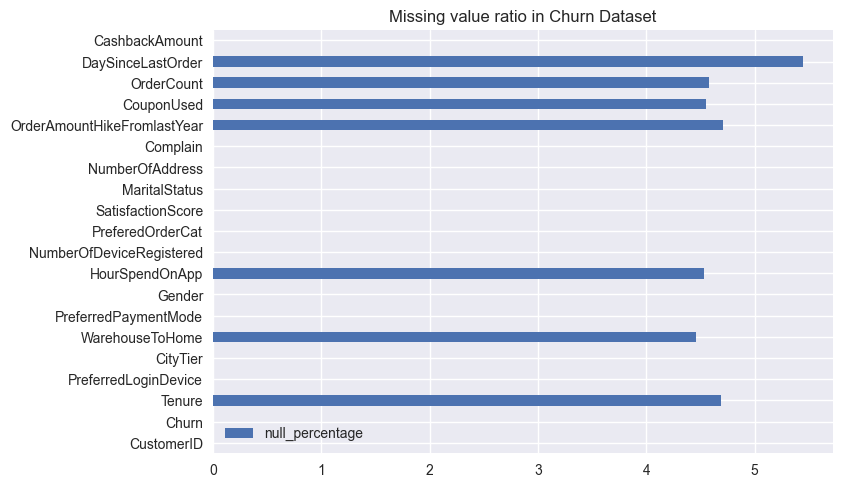

In [14]:
# Check missing values percentage of each column
missing_values_df = (churn_df
    .isna()
    .sum()
    .to_frame('null_count')
)

missing_values_df['null_percentage'] = round(missing_values_df['null_count'] / churn_df.shape[0] * 100, 2)
missing_values_df[['null_percentage']].plot(kind='barh', title='Missing value ratio in Churn Dataset')

pyplot.show()

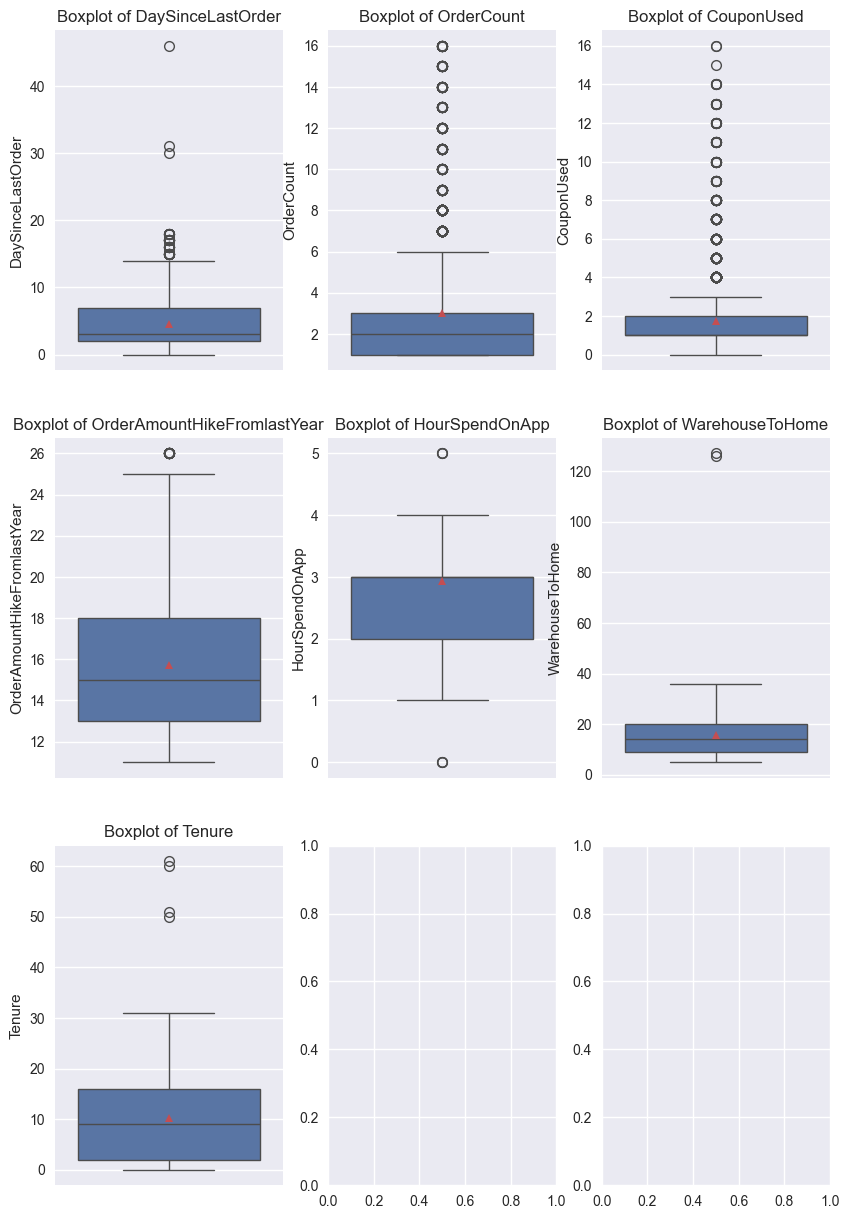

In [15]:
# Create boxplots to see if the numeric columns with missing values have outliers

# Create subplots to display multiple charts in the same canvas
subplot_row, subplot_col = (3,3)
fig, axes = pyplot.subplots(nrows=subplot_row, ncols=subplot_col, figsize=(10, 15)) 
numeric_columns = ['DaySinceLastOrder', 'OrderCount', 'CouponUsed', 'OrderAmountHikeFromlastYear', 'HourSpendOnApp', 'WarehouseToHome', 'Tenure']

# Boxplotting to show comparison for all numeric_columns
for column, (nrow, ncol) in zip(numeric_columns, [(row, col) for row in range(subplot_row) for col in range(subplot_col)]):
    
    current_ax = axes[nrow][ncol]
    seaborn.boxplot(
        y=column, 
        data=churn_df, 
        showmeans=True,
        ax=current_ax # Set position of current subplot based on current_ax
    )
    current_ax.set_title(f'Boxplot of {column}')

pyplot.show()

Since all of numeric columns have outliers, to fill missing data with median

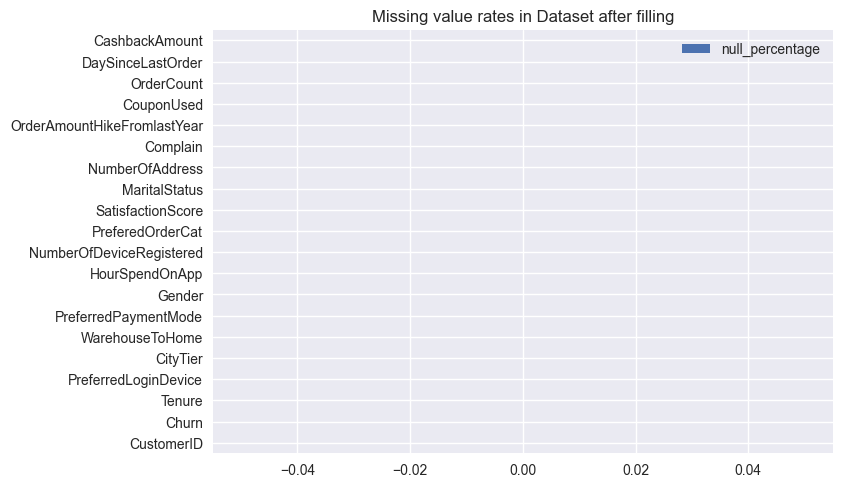

In [16]:
# Fill the numberic columns with missing values
for col in ['DaySinceLastOrder', 'OrderCount', 'CouponUsed', 'OrderAmountHikeFromlastYear', 'HourSpendOnApp', 'WarehouseToHome', 'Tenure']:
    churn_df[col].fillna(
        value=round(churn_df[col].median()),
        inplace=True
    )

# Check missing values percentage of each column after filling
missing_values_df = (churn_df
    .isna()
    .sum()
    .to_frame('null_count')
)

missing_values_df['null_percentage'] = round(missing_values_df['null_count'] / churn_df.shape[0] * 100, 2)
missing_values_df[['null_percentage']].plot(kind='barh', title='Missing value rates in Dataset after filling')

pyplot.show()

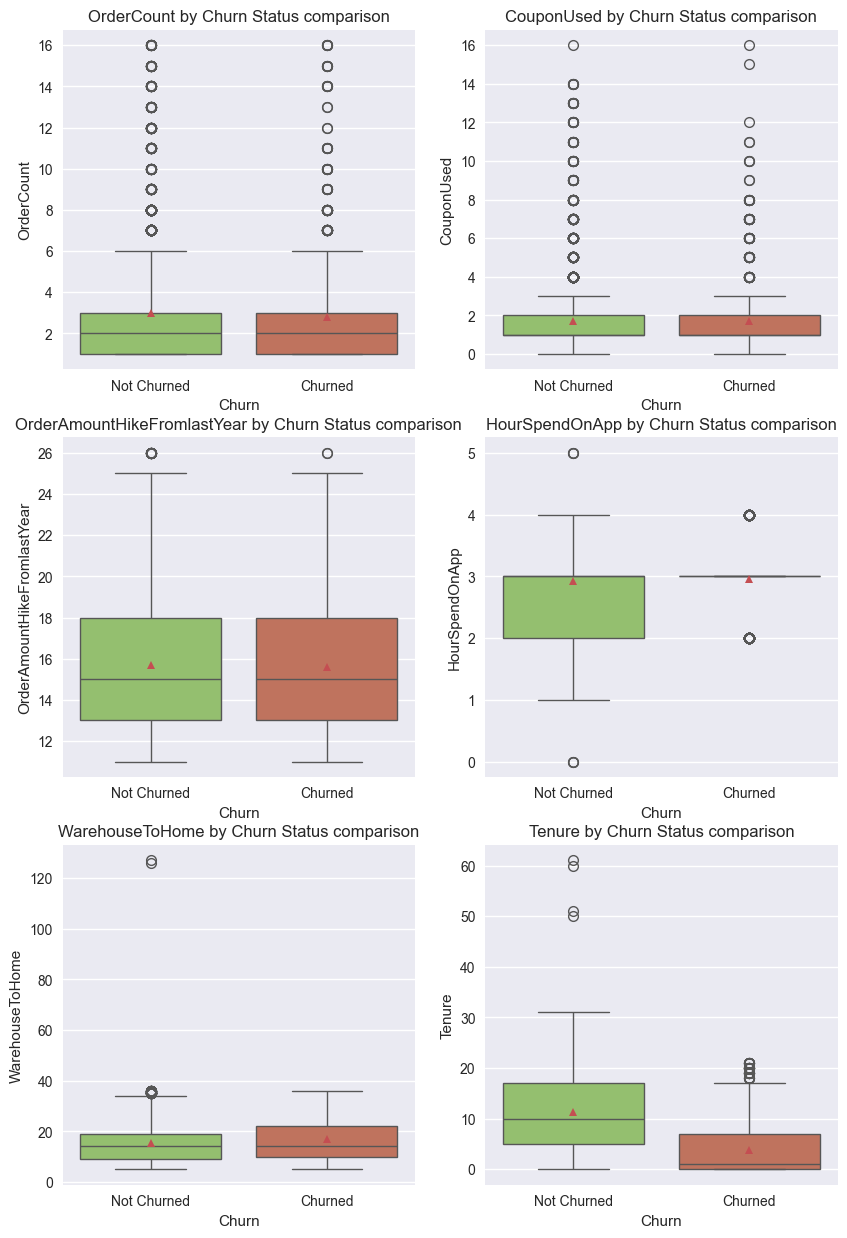

In [17]:
# Comparing Churned and Not churned users among numeric data

# Create subplots to display multiple charts in the same canvas
subplot_row, subplot_col = (3,2)
fig, axes = pyplot.subplots(nrows=subplot_row, ncols=subplot_col, figsize=(10, 15)) 
numeric_columns = ['OrderCount', 'CouponUsed', 'OrderAmountHikeFromlastYear', 'HourSpendOnApp', 'WarehouseToHome', 'Tenure']

# Boxplotting to show comparison for all numeric_columns
for column, (nrow, ncol) in zip(numeric_columns, [(row, col) for row in range(subplot_row) for col in range(subplot_col)]):
    current_ax = axes[nrow][ncol]
    seaborn.boxplot(
        x='Churn', 
        y=column, 
        data=churn_df, 
        showmeans=True,
        palette=['#93cc62', '#cf6a4e'],
        ax=current_ax
    )
    current_ax.set_title(f'{column} by Churn Status comparison')
    current_ax.set_xticks(ticks=[0,1], rotation=0)
    current_ax.set_xticklabels(['Not Churned', 'Churned'])

pyplot.show()

From the comparison, it appears the following factors remarkably retain customers:
- Tenure: the longer the tenure, the higher the chance to retain

The following factor seems
- WarehouseToHome: the further from warehouse the higher chance to churn

The following factors don't seem remarkably affect the churning decisions:
- OrderCount, CouponUsed, OrderAmountHikeFromlastYear, HourSpendOnApp

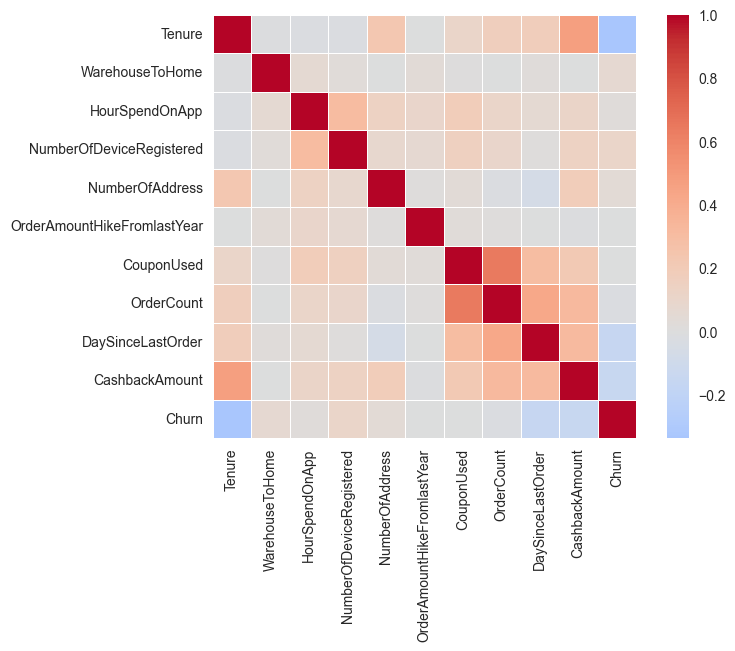

In [18]:
# Correlation of each numeric column

corr_df = churn_df[['Tenure', 'WarehouseToHome', 'HourSpendOnApp','NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount', 'Churn']]

seaborn.heatmap(
    corr_df.corr(), 
    fmt=".2f", 
    cmap='coolwarm', 
    center=0, 
    square=True, 
    linewidths=.5
)

pyplot.show()

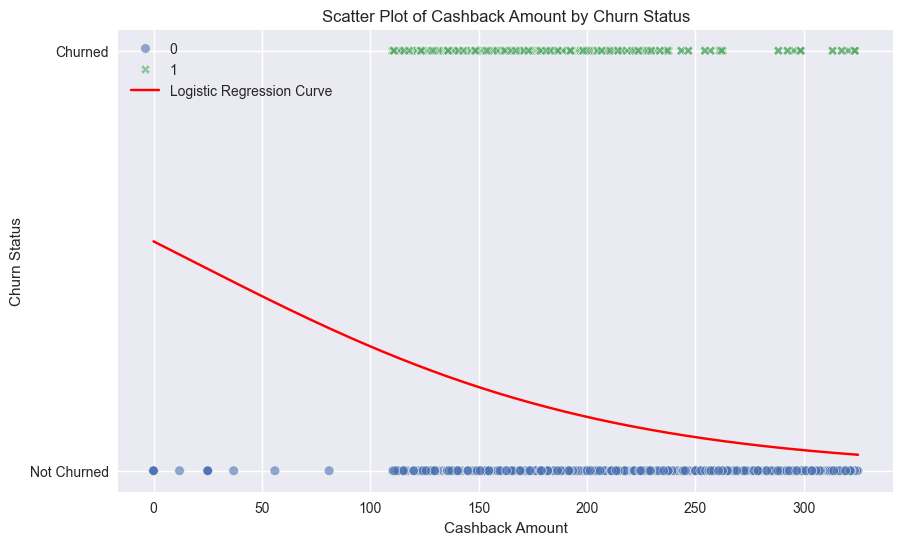

In [19]:
# Example of Scatter Plot with Logistic Regression Curve by ChatGPT 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Assuming churn_df is your DataFrame and it has already been loaded

# Initializing cashbackAmount and churn from churn_df
cashbackAmount = churn_df['CashbackAmount'].values.reshape(-1, 1)  # Reshape for consistency
churn = churn_df['Churn'].values

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CashbackAmount', y='Churn', data=churn_df, alpha=0.6, hue='Churn', style='Churn', markers={0: 'o', 1: 'X'})
plt.title('Scatter Plot of Cashback Amount by Churn Status')
plt.xlabel('Cashback Amount')
plt.ylabel('Churn Status')
plt.yticks([0, 1], ['Not Churned', 'Churned'])

# Fitting a Logistic Regression for visualization purposes
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cashbackAmount)
model = LogisticRegression()
model.fit(X_scaled, churn)

# Generating values for predictions
X_test = np.linspace(X_scaled.min(), X_scaled.max(), 300).reshape(-1, 1)  # Ensure it's 2D for prediction
# Predicting probabilities
probs = model.predict_proba(X_test)[:, 1]

# Adjusting X_test back to the original scale for plotting
X_test_original = scaler.inverse_transform(X_test).flatten()  # Flatten to make it 1D for plotting

# Adding logistic regression curve
plt.plot(X_test_original, probs, color='red', label='Logistic Regression Curve')
plt.legend()
plt.show()


## Behaviour Observation 1:

From the correlation heatmap, it appears the following factor(s) remarkably retain customers:

- Tenure: the longer the tenure, the higher the chance to retain

And following factor(s) may negatively affect the retention
- CashbackAmount: lower cashback might be associated with higher churn rates

The following factor(s) seems significantly associate to each other:
- OrderCount and CouponUsed: who place more orders tend to use more coupons
- OrderCount and DaySinceLastOrder: customers who place orders more frequently may have a recently closer last order
- CashbackAmount and Tenure: could imply that more tenured customers receive more 
- CashbackAmount and OrderCount
- CashbackAmount and DaySinceLastOrder
- HourSpendOnApp and NumberOfDeviceRegistered: customers with more devices spend more time on the app




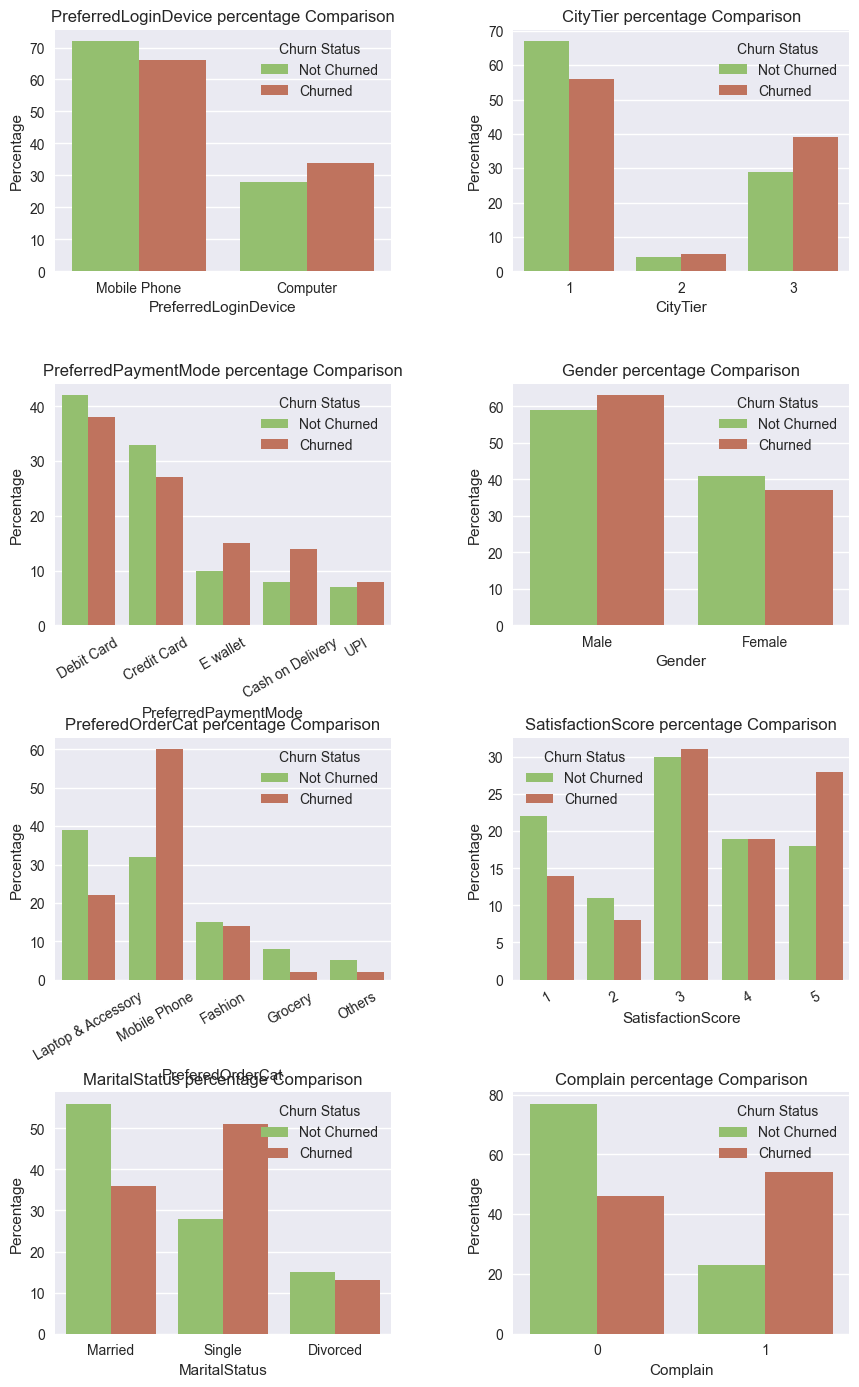

In [20]:
# Compare Percentage of each categorical column by churn status

# Initiate subplots to display multiple charts
subplot_row, subplot_col = (4,2)
figure, axes = pyplot.subplots(nrows=subplot_row, ncols=subplot_col, figsize=(10, 15))
figure.tight_layout(pad=6.0)

categorical_columns = ['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'Complain']

# Loop through the list to plot Bar chart displaying percent of each element by Churn status
for column, (nrow, ncol) in zip(categorical_columns, [(row, col) for row in range(subplot_row) for col in range(subplot_col)]):
    # Calculate percent column
    sub_df = churn_df[['Churn', column]].value_counts().rename('Count').reset_index()
    sub_df['Percentage'] = round(sub_df['Count'] / sub_df.groupby(by='Churn')['Count'].transform('sum') * 100, 0) 
    
    # Set position of current_ax against subplot axes
    current_ax = axes[nrow][ncol]
    
    seaborn.barplot(
        x=column,
        y='Percentage',
        hue='Churn',
        data=sub_df,
        palette=[color_not_churned, color_churned],
        ax=current_ax
    )
    
    # Prepare parameters for Ax style
    ticks_rotation = 30 if sub_df[column].unique().size >= 5 else 0
    # Retrieve the ogirinal handle object from current_ax to keep same legend colours
    handles, labels = current_ax.get_legend_handles_labels()
    
    current_ax.legend(handles=handles, title='Churn Status', labels=['Not Churned', 'Churned'])
    current_ax.set_title(f'{column} percentage Comparison')
    current_ax.tick_params(axis='x', rotation=ticks_rotation)

pyplot.show()

In [13]:
# Try out Chi-Square test to see if there is any statistical significance between each ahc of the categorical columns and Churn status
# Null Hypothesis (H0): There is no association between the categorical variable and churn status.
# Alternative Hypothesis (H1): There is an association between the categorical variable and churn status.


from scipy.stats import chi2_contingency


categorical_columns = ['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'Complain']

chi2_df = pandas.DataFrame(columns=['Feature', 'Chi-Squared', 'P-value', 'Degrees of freedom', 'Expected frequencies', 'Significance'])


for col in categorical_columns:
    #     # Create pivot between current column and churn status

    contingency_table = pandas.crosstab(churn_df[col], churn_df['Churn'])
    # Perform the Chi-Squared Test
    chi2, p_value, dof, ef = chi2_contingency(contingency_table)
    chi2_df = chi2_df.append(
        {
            'Feature': col, 
            'Chi-Squared': chi2, 
            'P-value': p_value, 
            'Degrees of freedom': dof, 
            'Expected frequencies': ef,
            'Significance': 'Statistically Significant' if p_value < 0.05 else 'Not Significant'
        }, 
        ignore_index=True
    )
    

chi2_df




,Feature,Chi-Squared,P-value,Degrees of freedom,Expected frequencies,Significance
0,PreferredLoginDevice,14.401253,1.477040e-04,1,"[[1358.8611012433394, 275.13889875666075], [33...",Statistically Significant
1,CityTier,40.982404,1.261200e-09,2,"[[3048.7055062166964, 617.2944937833038], [201...",Statistically Significant
2,PreferredPaymentMode,51.828960,1.497857e-10,4,"[[427.45079928952043, 86.54920071047957], [147...",Statistically Significant
3,Gender,4.662908,3.082094e-02,1,"[[1867.810301953819, 378.18969804618115], [281...",Statistically Significant
4,PreferedOrderCat,288.597786,3.119243e-61,4,"[[686.9150976909414, 139.0849023090586], [340....",Statistically Significant
5,SatisfactionScore,69.865388,2.423335e-14,4,"[[968.0014209591475, 195.99857904085258], [487...",Statistically Significant
6,MaritalStatus,188.671040,1.073011e-41,2,"[[705.2106571936057, 142.7893428063943], [2483...",Statistically Significant
7,Complain,350.925455,2.664461e-78,1,"[[3348.0873889875666, 677.9126110124334], [133...",Statistically Significant


In [14]:
# Try out Chi-Square test to see if there is any statistical significance between each categorical column mutually
# Null Hypothesis (H0): There is no association between the categorical variable and churn status.
# Alternative Hypothesis (H1): There is an association between the categorical variable and churn status.


from scipy.stats import chi2_contingency


categorical_columns_w_churn = ['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'Complain', 'Churn']

chi2_mutual_df = pandas.DataFrame(columns=['Feature 1', 'Feature 2', 'Chi-Squared', 'P-value', 'Degrees of freedom', 'Expected frequencies', 'Significance'])


for col1 in categorical_columns_w_churn[:-1]:
    for col2 in categorical_columns_w_churn[1:]:
        if col1 == col2:
            continue
        # Create pivot between 2 columns
        contingency_table = pandas.crosstab(churn_df[col1], churn_df[col2])
        # Perform the Chi-Squared Test
        chi2, p_value, dof, ef = chi2_contingency(contingency_table)
        chi2_mutual_df = chi2_mutual_df.append(
            {
                'Feature 1': col1,
                'Feature 2': col2, 
                'Chi-Squared': chi2, 
                'P-value': p_value, 
                'Degrees of freedom': dof, 
                'Expected frequencies': ef,
                'Significance': 'Statistically Significant' if p_value < 0.05 else 'Not Significant'
            }, 
            ignore_index=True
        )
    

chi2_mutual_df[chi2_mutual_df['Significance'] == 'Statistically Significant']

,Feature 1,Feature 2,Chi-Squared,P-value,Degrees of freedom,Expected frequencies,Significance
1,PreferredLoginDevice,PreferredPaymentMode,11.612717,2.047601e-02,4,"[[149.17868561278863, 514.8696269982238, 671.5...",Statistically Significant
3,PreferredLoginDevice,PreferedOrderCat,21.412133,2.623164e-04,4,"[[239.73072824156304, 118.99467140319716, 594....",Statistically Significant
4,PreferredLoginDevice,SatisfactionScore,15.452466,3.849165e-03,4,"[[337.82877442273536, 170.0753108348135, 492.8...",Statistically Significant
7,PreferredLoginDevice,Churn,14.401253,1.477040e-04,1,"[[1358.8611012433394, 275.13889875666075], [33...",Statistically Significant
8,CityTier,PreferredPaymentMode,2147.607086,0.000000e+00,8,"[[334.69342806394314, 1155.148134991119, 1506....",Statistically Significant
9,CityTier,Gender,13.719928,1.048952e-03,2,"[[1462.4930728241563, 2203.506927175844], [96....",Statistically Significant
10,CityTier,PreferedOrderCat,534.991426,2.171535e-110,8,"[[537.8536412078153, 266.9733570159858, 1334.8...",Statistically Significant
11,CityTier,SatisfactionScore,44.001388,5.686150e-07,8,"[[757.9438721136768, 381.5765541740675, 1105.6...",Statistically Significant
12,CityTier,MaritalStatus,23.924517,8.270615e-05,4,"[[552.1790408525754, 1944.3474245115453, 1169....",Statistically Significant
14,CityTier,Churn,40.982404,1.261200e-09,2,"[[3048.7055062166964, 617.2944937833038], [201...",Statistically Significant


## Behaviour Observation 2:

From the percentage comparison, it appears the following factors remarkably retain customer:

- PreferredPaymentMode: Credit Card
- PreferedOrderCat: Laptop & Accessory, Grocery and Others
- SatisfactionScore: Rate 1
- MaritalStatus: Married
- Complain: has no complain

And the following factors draw customers away from the service:
- PreferredPaymentMode: E-wallet, Cash on Delivery
- PreferedOrderCat: Mobile phone
- SatisfactionScore: Rate 5
- MaritalStatus: Single
- Complain: has complain

And the following factors does not significantly affect the churning behaviours: 
- CityTier
- Gender

## From the 2 behaviour observations, following improvements are advised:
- Improve **_tenure_** by running loyalty programs to reward long-term customers
- Improve **_cashback_** strategy since higher cashback amounts are associated with lower churn
- Improve experience of payment methods such as 'E-wallet' and 'Cash on delivery' since these groups show a higher likelihood of churning
- Address the complaints from customers to increase retention

- Develop marketing campaigns that 
  - offer coupons to customers who haven't ordered recently
  - target married customers as they tend to stay longer with the service
  - focus on product categories with high retention, such as 'Laptop & Accessory', 'Grocery', and 'Others'.
- Develop promotion campaigns for customers using 'Credit Card' payments


The company can perform A/B testing for these improvements to see how the changes go.


# Feature Transforming

In [19]:
# Encode categorical columns
category_columns = ['PreferredLoginDevice', 'CityTier', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'SatisfactionScore', 'MaritalStatus', 'Complain']

encoded_churn_df = churn_df[category_columns]

encoded_churn_df = (pandas
    .get_dummies(encoded_churn_df, columns=category_columns, prefix=category_columns)
    .copy()
)

encoded_churn_df.columns

Index(['PreferredLoginDevice_Computer', 'PreferredLoginDevice_Mobile Phone',
       'CityTier_1', 'CityTier_2', 'CityTier_3',
       'PreferredPaymentMode_Cash on Delivery',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'Gender_Female', 'Gender_Male', 'PreferedOrderCat_Fashion',
       'PreferedOrderCat_Grocery', 'PreferedOrderCat_Laptop & Accessory',
       'PreferedOrderCat_Mobile Phone', 'PreferedOrderCat_Others',
       'SatisfactionScore_1', 'SatisfactionScore_2', 'SatisfactionScore_3',
       'SatisfactionScore_4', 'SatisfactionScore_5', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single', 'Complain_0',
       'Complain_1'],
      dtype='object')

In [20]:
# Normalise numeric columns
from sklearn.preprocessing import MinMaxScaler

numeric_columns = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp','NumberOfDeviceRegistered', 'NumberOfAddress', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

scaler = MinMaxScaler()
scaler_model = scaler.fit(churn_df[numeric_columns])

transformed_data = scaler_model.transform(churn_df[numeric_columns])

normalised_churn_df = pandas.DataFrame(transformed_data, columns= numeric_columns)

normalised_churn_df.columns

Index(['Tenure', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'NumberOfAddress',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [21]:
# Combine 2 encoded and normalised data frames
processed_churn_df = normalised_churn_df.join(encoded_churn_df)

processed_churn_df.columns

Index(['Tenure', 'WarehouseToHome', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'NumberOfAddress',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount', 'PreferredLoginDevice_Computer',
       'PreferredLoginDevice_Mobile Phone', 'CityTier_1', 'CityTier_2',
       'CityTier_3', 'PreferredPaymentMode_Cash on Delivery',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'Gender_Female', 'Gender_Male', 'PreferedOrderCat_Fashion',
       'PreferedOrderCat_Grocery', 'PreferedOrderCat_Laptop & Accessory',
       'PreferedOrderCat_Mobile Phone', 'PreferedOrderCat_Others',
       'SatisfactionScore_1', 'SatisfactionScore_2', 'SatisfactionScore_3',
       'SatisfactionScore_4', 'SatisfactionScore_5', 'MaritalStatus_Divorced',
       'MaritalStatus_Married', 'MaritalStatus_Single', 'Complain_0',
       'Complain_1'],
      dtype=

# Model Training - Random Forest and fine tune with Grid Search Cross-validation

In [38]:
# Split the train and test datasets
from sklearn.model_selection import train_test_split

x = processed_churn_df
y = churn_df[['Churn']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

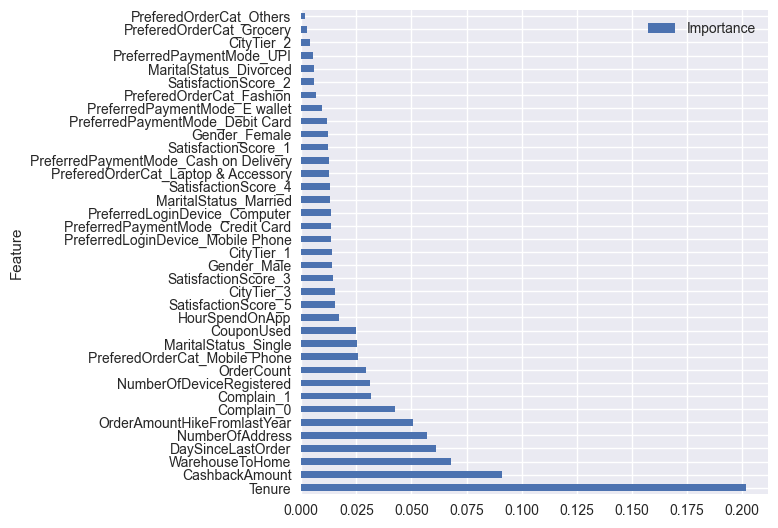

In [39]:
# Apply Random Forest model to retrieve Feature Importance level
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on training data
rf_model.fit(x_train, y_train)

# Visualise importance ranking
feature_importance_df = pandas.DataFrame()
feature_importance_df['Feature'] = x_train.columns
feature_importance_df['Importance'] = rf_model.feature_importances_
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance_df['Cumulative Importance'] = feature_importance_df['Importance'].cumsum()


feature_importance_df.plot(
    kind='barh',
    x='Feature',
    y='Importance'
)

pyplot.tight_layout(pad=1.5)
pyplot.show()

In [40]:
feature_importance_df.sort_values(by='Importance', ascending=False)

,Feature,Importance,Cumulative Importance
0,Tenure,0.201863,0.201863
9,CashbackAmount,0.091296,0.293159
1,WarehouseToHome,0.068066,0.361226
8,DaySinceLastOrder,0.061072,0.422298
4,NumberOfAddress,0.057069,0.479366
5,OrderAmountHikeFromlastYear,0.050853,0.530219
35,Complain_0,0.042624,0.572842
36,Complain_1,0.031792,0.604634
3,NumberOfDeviceRegistered,0.031224,0.635859
7,OrderCount,0.029258,0.665116


In [41]:
# Assume a feature importance threshold
feature_importance_threshold = 0.8 # Because it seems 0.8 produces the best possible balanced_accuracy_score 🤷‍♂️

# Select the feature based on feature importance threshold
optimised_features = feature_importance_df[feature_importance_df['Cumulative Importance'] <= feature_importance_threshold]['Feature'].values

print(f'Selected {optimised_features.size} features: \n{optimised_features}')

Selected 16 features: 
['Tenure' 'CashbackAmount' 'WarehouseToHome' 'DaySinceLastOrder'
 'NumberOfAddress' 'OrderAmountHikeFromlastYear' 'Complain_0' 'Complain_1'
 'NumberOfDeviceRegistered' 'OrderCount' 'PreferedOrderCat_Mobile Phone'
 'MaritalStatus_Single' 'CouponUsed' 'HourSpendOnApp'
 'SatisfactionScore_5' 'CityTier_3']


In [42]:
# Create a new DataFrame with only selected features
x_train_optimised = x_train[optimised_features]
x_test_optimised = x_test[optimised_features]

rf_optimised = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on training data with selected features
rf_optimised.fit(x_train_optimised, y_train)

# Apply model on train set and test set: 
y_rf_prediction_train = rf_optimised.predict(x_train_optimised)
y_rf_prediction_test = rf_optimised.predict(x_test_optimised)

In [43]:
from sklearn.metrics import balanced_accuracy_score

# Calculate the balanced accuracy on train set and test set to check overfiting and underfiting: 
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_rf_prediction_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_rf_prediction_test)}')

Balance accuracy of train set: 1.0
Balance accuracy of test set: 0.8984452607018274


In [42]:
# Apply GridSearchCV to find best set of parameter

from sklearn.model_selection import GridSearchCV

# Input the parameter grid: 
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(rf_optimised, param_grid, cv=5, scoring='balanced_accuracy')

# Fit the model
grid_search.fit(x_train_optimised, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

In [43]:
# Evaluate the best model on the train and test sets

best_clf = grid_search.best_estimator_
train_accuracy = best_clf.score(x_train_optimised, y_train)
test_accuracy = best_clf.score(x_test_optimised, y_test)

print("Accuracy of train set: ", train_accuracy)
print("Accuracy of test set: ", test_accuracy)

Accuracy of train set:  1.0
Accuracy of test set:  0.9655543595263725


Accuracy of test set is greatly improved after applying Grid Search CV: 0.89 -> 0.96

# Model Training - Logistic Regression

In [44]:
# Split the train and test datasets again for Logistic Regression, use all features

x = processed_churn_df
y = churn_df[['Churn']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [45]:
# Apply Logistic Regression model
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state = 0)

# Fit the train set to model 
lr_model.fit(x_train, y_train)

# Make prediction with Test dataset
y_pred_test = lr_model.predict(x_test)
y_pred_train = lr_model.predict(x_train)

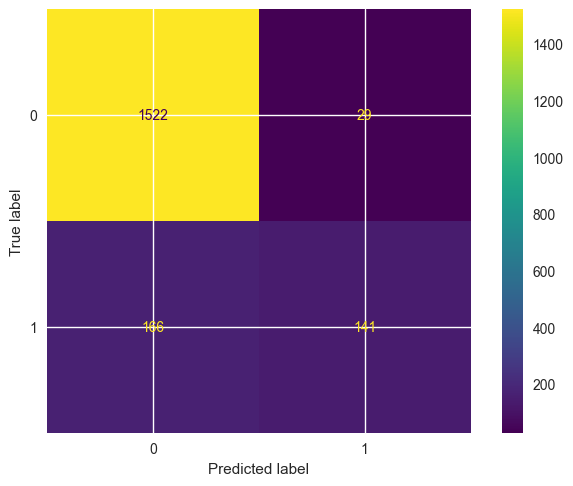

In [46]:
# Check Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_test, labels=lr_model.classes_)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
cm_display.plot()

In [47]:
# Calculate balance accuracy for Logistic Regression Model
balanced_accuracy_train = balanced_accuracy_score(y_train, y_pred_train)sheet
balanced_accuracy_test = balanced_accuracy_score(y_test, y_pred_test)

print(f'Balance accuracy of train set: {balanced_accuracy_train}')
print(f'Balance accuracy of test set: {balanced_accuracy_test}')

Balance accuracy of train set: 0.7191947467103411
Balance accuracy of test set: 0.7202928865899272


It appears Logistic Regression model produces less accuracy of prediction than what Random Forest can do